In [ ]:
import jax.numpy as np
import jax
from jax import grad, jacfwd, hessian, jacrev
from jax import vmap
from jax import jit
from jax import random
from jax.lax import cond 
import numpy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def sigmoid(x):
    #return x/(1. + np.exp(-x))
    #return np.tanh(x)
    return 1./(1. + np.exp(-x))

In [ ]:
def nn_V(params, t, c):
    M0 = c['M0']
    M1 = c['M1']
    M2 = c['M2']
    #t = (t/c['t1'] -0.5)*2.
    t = (t - c['t0'])/(c['t1']- c['t0']) -0.5
    w0 = params[:M0]#np.reshape(params[:M0], (1, M0))
    b0 = params[M0:2*M0]
    w1 = np.reshape(params[2*M0: 2*M0 + M0*M1], (M0, M1))
    b1 = params[2*M0 + M0*M1: 2*M0 + M0*M1 + M1]
    w2 = np.reshape(params[2*M0 + M0*M1 + M1: 2*M0 + M0*M1 + M1 + M1*M2], (M1, M2))
    b2 = params[2*M0 + M0*M1 + M1 + M1*M2 : 2*M0 + M0*M1 + M1 + M1*M2+M2]
    w3 = np.reshape(params[2*M0 + M0*M1 + M1 + M1*M2+M2:2*M0 + M0*M1 + M1 + M1*M2+M2+4*M2], (M2, 4))
    b3 = params[2*M0 + M0*M1 + M1 + M1*M2+M2+4*M2 : 2*M0 + M0*M1 + M1 + M1*M2+M2+4*M2+4]

    t0 = sigmoid(np.tensordot(t, w0, 0, precision=jax.lax.Precision.HIGHEST) + b0)
    #t0 = sigmoid(np.dot(t, w0) + b0)
    t1 = sigmoid(np.dot(t0, w1) + b1)
    t2 = sigmoid(np.dot(t1, w2) + b2) #+ t0
    t3 = np.dot(t2, w3) + b3 
    res = np.array([c['ics'][0] + (t+0.5)*t3[0],
                    c['ics'][1] + (t+0.5)*t3[1], 
                    (0.5-t)*t3[2], (0.5-t)*t3[3]]) #phi, rho, l1,l2
    return res

v_nn_V = jax.vmap(nn_V, (None, 0, None))
dNNdt_V = jacrev(nn_V, 1)#jacrev(nn, 1)
v_dNNdt_V = jax.vmap(dNNdt_V, (None, 0, None), 0)

In [ ]:
def loss(params, t, c):
    M0 = c['M0']
    M1 = c['M1']
    M2 = c['M2']
    vals = v_nn_V(params, t, c)
    phi = vals[:, 0]
    rho = vals[:, 1]
    L1 = vals[:, 2]
    L2 = vals[:, 3]

    tmp = v_dNNdt_V(params, t, c)
    dphi = tmp[:, 0]
    drho = tmp[:, 1]
    dL1 = tmp[:, 2]
    dL2 = tmp[:, 3]

    H0 = L2*(-c['k']*rho + c['N']*phi*(1.-0.)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - rho/c['rhoMax'] * phi*(1.-0.)*c['v'])
    H1 = L2*(-c['k']*rho + c['N']*phi*(1.-0.9)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*0.9*0.9 - rho/c['rhoMax'] * phi*(1.-0.9)*c['v'])

    utest = np.clip(0.5*(-L2*c['N']*c['rhoMax'] + rho*c['v'] - c['n']*rho*c['v'] + c['n']*L1*rho*c['v'])/(c['rhoMax']*(1. - c['n']+ c['n']*L1)),0., 0.9)
    Hu = L2*(-c['k']*rho + c['N']*phi*(1-utest)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*utest*utest - rho/c['rhoMax'] * phi*(1.-utest)*c['v'])

    #u = np.zeros(len(utest)) - 2.0
    u = np.where(H0 > H1, np.zeros(len(utest)), np.ones(len(utest)) - 0.1)

    H = np.where(H0 > H1, H0, H1)

    
    u = np.where(Hu >= H, utest, u)
    #u = np.where(u > Hu, u, utest)
    res = 0.
    res += (dphi - (-c['b']*phi + c['n']*(c['z']*phi - phi*u*u - rho/c['rhoMax'] * phi*(1.-u)*c['v'])))**2
    res += (drho - (-c['k']*rho + c['N']*phi*(1.-u)))**2

    res += (dL1 + (L2*c['N']*(1.-u) - c['b']*L1 + 
                   (1.-c['n']+c['n']*L1)*(c['z'] - u*u - rho/c['rhoMax'] * (1.-u)*c['v'])))**2
    res += (dL2 + (-L2*c['k'] - 
                   ((1.-c['n']+c['n']*L1)*phi*(1.-u)*c['v'])/c['rhoMax']))**2
    
    return res.mean()

dLoss = grad(loss, 0)

In [ ]:
consts = {'N':1, 'M0':4, 'M1': 16, 'M2': 64, 'ics': [1., 0.], 't0':0., 't1':1., 'rhoMax': 1., 'b': 0.5, 'n': 0.5, 'k':0.5, 'z': 0.1, 'v':1.0}
#consts = {'N':3., 'M0':4, 'M1': 32, 'M2': 128, 'ics': [1., 0.], 't0':0., 't1':5., 'rhoMax': 1., 'b': 0.01, 'n': 0.99, 'k':0.95, 'z': 1.0, 'v':1.0}

In [ ]:
inputs = np.linspace(consts['t0'], consts['t1'], num=5000)

In [ ]:
epochs = 2500

learning_rate = 0.01
#inputs = np.linspace(np.array([0., 1e-4]), np.array([consts['t1']-1e-4, consts['ics'][0]]), num=501)
batch_size = 500
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(2*M0 + M0*M1 + M1 + M1*M2+M2+4*M2+4, )))*0.1
#params = params - params.min()
#params /= params.max()
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams = params
ec = 1

In [ ]:
bad_ep = 0
step = -1e-4
k = 0
PastParams = params
max_lr=0.2
for epoch in range(epochs):
    i = numpy.random.randint(0, inputs.shape[0], size=batch_size)
    #sample = inputs[i]
    sample = inputs
    #rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, -0.0005, 0.0005)
    #sample += rnd
    #sample = numpy.clip(sample, consts['t0'], consts['t1'] - 1e-4)
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    #if bad_ep >= 50:
      #k = 250
      #learning_rate = learning_rate + step
      #bad_ep = 0
    if learning_rate <= 1e-8:
      step= 1e-2
      #PastParams = PastParams + 0.75*(params - PastParams)
      #k = 0
      #params = PastParams
      #v = 0.0
      #m = 0.0

    if learning_rate >= max_lr:
      step = -1e-3
    if epoch % ec == 0:
      currLoss = loss(params, inputs, consts)
      #print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
        print('Loss Updated!')
        print(' ')
        bestParams = params
        bestLoss = currLoss
        bad_ep = 0
      else:
        bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

         # bad_ep=0

    gradient = dLoss(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))##*gradient#
    params += velocity

    k += 1
    #if k == 200:
    #  PastParams = PastParams + 0.5*(params - PastParams)
    #  k = 0
    #  params = PastParams
      #max_lr = max(0.99*max_lr, 0.1)

epoch: %3d loss: %.6f lr: %.6f (0, DeviceArray(7.6977086, dtype=float32), 0.0099)
Loss Updated!
 


KeyboardInterrupt: ignored

In [ ]:
with open('/content/gdrive/My Drive/EX2.npy', 'wb') as f:
    np.save(f, bestParams)

In [ ]:
bestParams = np.load('/content/gdrive/My Drive/EX2.npy', allow_pickle=True)

In [ ]:
loss(bestParams, inputs, consts)

DeviceArray(9.308192e-06, dtype=float32)

In [ ]:
consts['w0'] = np.load('/content/gdrive/My Drive/EX2.npy', allow_pickle=True)

In [ ]:
def defect(t, c):
    vals = v_nn_V(c['w0'], t, c)
    phi = vals[:, 0]
    rho = vals[:, 1]
    L1 = vals[:, 2]
    L2 = vals[:, 3]

    tmp = v_dNNdt_V(c['w0'], t, c)
    dphi = tmp[:, 0]
    drho = tmp[:, 1]
    dL1 = tmp[:, 2]
    dL2 = tmp[:, 3]

    H0 = L2*(-c['k']*rho + c['N']*phi*(1.-0.)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - rho/c['rhoMax'] * phi*(1.-0.)*c['v'])
    H1 = L2*(-c['k']*rho + c['N']*phi*(1.-0.9)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*0.9*0.9 - rho/c['rhoMax'] * phi*(1.-0.9)*c['v'])

    utest = np.clip(0.5*(-L2*c['N']*c['rhoMax'] + rho*c['v'] - c['n']*rho*c['v'] + c['n']*L1*rho*c['v'])/(c['rhoMax']*(1. - c['n']+ c['n']*L1)),0., 0.9)
    Hu = L2*(-c['k']*rho + c['N']*phi*(1-utest)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*utest*utest - rho/c['rhoMax'] * phi*(1.-utest)*c['v'])

    #u = np.zeros(len(utest)) - 2.0
    u = np.where(H0 > H1, np.zeros(len(utest)), np.ones(len(utest)) - 0.1)

    H = np.where(H0 > H1, H0, H1)

    
    u = np.where(Hu >= H, utest, u)
    #u = np.where(u > Hu, u, utest)

    res0 = dphi - (-c['b']*phi + c['n']*(c['z']*phi - phi*u*u - rho/c['rhoMax'] * phi*(1.-u)*c['v']))
    res1 = drho - (-c['k']*rho + c['N']*phi*(1.-u))

    res2 = dL1 + (L2*c['N']*(1.-u) - c['b']*L1 + 
                   (1.-c['n']+c['n']*L1)*(c['z'] - u*u - rho/c['rhoMax'] * (1.-u)*c['v']))
    res3 = (dL2 + (-L2*c['k'] - 
                   (1.-c['n']+c['n']*L1)*phi*(1.-u)*c['v'])/c['rhoMax'])
    return np.array([res0, res1, res2, res3])

In [ ]:
def loss2(params, t, c):
    vals = v_nn_V(params, t, c)
    phi = vals[:, 0]
    rho = vals[:, 1]
    L1 = vals[:, 2]
    L2 = vals[:, 3]

    tmp = v_dNNdt_V(params, t, c)
    dphi = tmp[:, 0]
    drho = tmp[:, 1]
    dL1 = tmp[:, 2]
    dL2 = tmp[:, 3]

    H0 = L2*(-c['k']*rho + c['N']*phi*(1.-0.)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - rho/c['rhoMax'] * phi*(1.-0.)*c['v'])
    H1 = L2*(-c['k']*rho + c['N']*phi*(1.-0.9)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*0.9*0.9 - rho/c['rhoMax'] * phi*(1.-0.9)*c['v'])

    utest = np.clip(0.5*(-L2*c['N']*c['rhoMax'] + rho*c['v'] - c['n']*rho*c['v'] + c['n']*L1*rho*c['v'])/(c['rhoMax']*(1. - c['n']+ c['n']*L1)),0., 0.9)
    Hu = L2*(-c['k']*rho + c['N']*phi*(1-utest)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*utest*utest - rho/c['rhoMax'] * phi*(1.-utest)*c['v'])

    #u = np.zeros(len(utest)) - 2.0
    u = np.where(H0 > H1, np.zeros(len(utest)), np.ones(len(utest)) - 0.1)

    H = np.where(H0 > H1, H0, H1)

    
    u = np.where(Hu >= H, utest, u)
    #u = np.where(u > Hu, u, utest)
    d = defect(t, c)
    res = 0.
    res += (dphi - (-c['b']*phi + c['n']*(c['z']*phi - phi*u*u - rho/c['rhoMax'] * phi*(1.-u)*c['v']) + d[0]))**2
    res += (drho - (-c['k']*rho + c['N']*phi*(1.-u) + d[1]))**2

    res += (dL1 - (-(L2*c['N']*(1.-u) - c['b']*L1 + 
                   (1.-c['n']+c['n']*L1)*(c['z'] - u*u - rho/c['rhoMax'] * (1.-u)*c['v'])) + d[2]))**2
    res += (dL2 - (-(-L2*c['k'] - 
                   ((1.-c['n']+c['n']*L1)*phi*(1.-u)*c['v'])/c['rhoMax']) + d[3]))**2
    
    return res.mean()

dLoss2 = grad(loss2, 0)

In [ ]:
epochs = 2500

learning_rate = 0.01
#inputs = np.linspace(np.array([0., 1e-4]), np.array([consts['t1']-1e-4, consts['ics'][0]]), num=501)
batch_size = 500
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(2*M0 + M0*M1 + M1 + M1*M2+M2+4*M2+4, )))*0.1
#params = params - params.min()
#params /= params.max()
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams2 = params
ec = 1

In [ ]:
bad_ep = 0
step = -1e-4
k = 0
PastParams = params
max_lr=0.2
for epoch in range(epochs):
    i = numpy.random.randint(0, inputs.shape[0], size=batch_size)
    #sample = inputs[i]
    sample = inputs
    #rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, -0.0005, 0.0005)
    #sample += rnd
    #sample = numpy.clip(sample, consts['t0'], consts['t1'] - 1e-4)
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    #if bad_ep >= 50:
      #k = 250
      #learning_rate = learning_rate + step
      #bad_ep = 0
    if learning_rate <= 1e-8:
      step= 1e-2
      #PastParams = PastParams + 0.75*(params - PastParams)
      #k = 0
      #params = PastParams
      #v = 0.0
      #m = 0.0

    if learning_rate >= max_lr:
      step = -1e-3
    if epoch % ec == 0:
      currLoss = loss2(params, inputs, consts)
      #print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
        print('Loss Updated!')
        print(' ')
        bestParams2 = params
        bestLoss = currLoss
        bad_ep = 0
      else:
        bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

         # bad_ep=0

    gradient = dLoss2(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))##*gradient#
    params += velocity

    k += 1
    #if k == 200:
    #  PastParams = PastParams + 0.5*(params - PastParams)
    #  k = 0
    #  params = PastParams
      #max_lr = max(0.99*max_lr, 0.1)

epoch: %3d loss: %.6f lr: %.6f (0, DeviceArray(7.6970673, dtype=float32), 0.0099)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (1, DeviceArray(3.0034494, dtype=float32), 0.009800000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (2, DeviceArray(0.7624082, dtype=float32), 0.009700000000000002)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (13, DeviceArray(0.51691306, dtype=float32), 0.008600000000000009)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (14, DeviceArray(0.3473135, dtype=float32), 0.00850000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (15, DeviceArray(0.30121088, dtype=float32), 0.00840000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (21, DeviceArray(0.25863057, dtype=float32), 0.007800000000000013)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (22, DeviceArray(0.21649829, dtype=float32), 0.007700000000000012)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (23, DeviceArray(0.18691644, dtype=float32), 0.007600000000000012)
Loss Updated!

In [ ]:
with open('/content/gdrive/My Drive/EX2_DEF.npy', 'wb') as f:
    np.save(f, bestParams2)

In [ ]:
w1 = np.load('/content/gdrive/My Drive/EX2.npy', allow_pickle=True)

In [ ]:
w2 = np.load('/content/gdrive/My Drive/EX2_DEF.npy', allow_pickle=True)

In [ ]:
inputs = np.linspace(consts['t0'], consts['t1'], num=100)

In [ ]:
with open('/content/gdrive/My Drive/EXAMPLE2.npy', 'wb') as f:
    np.save(f, {"consts": consts, "solution":w1, "defect": w2})

In [ ]:
loss2(w1, inputs, consts)

DeviceArray(0., dtype=float32)

In [ ]:
eX1 = []
eX2 = []
eL1 = []
eL2 = []
for t in inputs:
  eX1.append(nn_V(w2, t, consts)[0] - nn_V(w1, t, consts)[0])
  eX2.append(nn_V(w2, t, consts)[1] - nn_V(w1, t, consts)[1])
  eL1.append(nn_V(w2, t, consts)[2] - nn_V(w1, t, consts)[2])
  eL2.append(nn_V(w2, t, consts)[3] - nn_V(w1, t, consts)[3])

eX1 = np.array(eX1)
eL1 = np.array(eL1)
eX2 = np.array(eX2)
eL2 = np.array(eL2)

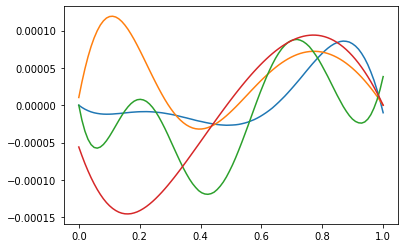

In [ ]:
plt.plot(inputs, eX1)
plt.plot(inputs, eL1)
plt.plot(inputs, eX2)
plt.plot(inputs, eL2)
plt.show()

In [ ]:
np.abs(eX1).max()

DeviceArray(8.583069e-05, dtype=float32)

In [ ]:
np.abs(eX2).max()

DeviceArray(0.00011927, dtype=float32)

In [ ]:
np.abs(eL1).max()

DeviceArray(0.0001191, dtype=float32)

In [ ]:
np.abs(eL2).max()

DeviceArray(0.00014552, dtype=float32)

**SHOOTING**

In [ ]:
def fun(t, y, c):
    phi = y[0]
    rho = y[1]
    L1 = y[2]
    L2 = y[3]

    H0 = L2*(-c['k']*rho + c['N']*phi*(1.-0.)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - rho/c['rhoMax'] * phi*(1.-0.)*c['v'])
    H1 = L2*(-c['k']*rho + c['N']*phi*(1.-0.9)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*0.9*0.9 - rho/c['rhoMax'] * phi*(1.-0.9)*c['v'])

    utest = np.clip(0.5*(-L2*c['N']*c['rhoMax'] + rho*c['v'] - c['n']*rho*c['v'] + c['n']*L1*rho*c['v'])/(c['rhoMax']*(1. - c['n']+ c['n']*L1)),0., 0.9)
    Hu = L2*(-c['k']*rho + c['N']*phi*(1-utest)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*utest*utest - rho/c['rhoMax'] * phi*(1.-utest)*c['v'])

    if (H0 > H1 and H0 > Hu):
      u = 0.0
    elif (H1 > H0 and H1 > Hu):
      u = 0.9
    else:
      u = utest

    dphi = (-c['b']*phi + c['n']*(c['z']*phi - phi*u*u - rho/c['rhoMax'] * phi*(1.-u)*c['v']))
    drho = (-c['k']*rho + c['N']*phi*(1.-u))

    dL1 = -(L2*c['N']*(1.-u) - c['b']*L1 + 
                   (1.-c['n']+c['n']*L1)*(c['z'] - u*u - rho/c['rhoMax'] * (1.-u)*c['v']))
    dL2 = -(-L2*c['k'] - 
                   ((1.-c['n']+c['n']*L1)*phi*(1.-u)*c['v'])/c['rhoMax'])
    
    return numpy.array([dphi, drho, dL1, dL2])

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [1. ,0., -0.49307835, -0.15152481], method='RK45', args=(consts,))

In [ ]:
sol.status

0

In [ ]:
sol.y

array([[ 1.        ,  0.99878159,  0.98657654,  0.86460811,  0.55086291],
       [ 0.        ,  0.0017237 ,  0.01865302,  0.15969319,  0.35348245],
       [-0.49307835, -0.49343058, -0.49695928, -0.53335914, -0.6672086 ],
       [-0.15152481, -0.15127422, -0.1488168 , -0.12878759, -0.10968412]])

In [ ]:
sol.y[2:, -1]

array([-0.6672086 , -0.10968412])

In [ ]:
def shootin_func(x, c):
    sol = solve_ivp(fun, (c['t0'], c['t1']), [c['ics'][0] ,c['ics'][1], x[0], x[1]], method='DOP853', args=(c,),atol =1e-8, rtol=1e-8)
    if sol.status == -1:
      raise NotImplementedError
      
    return sol.y[2:, -1]


In [ ]:
from scipy import optimize

In [ ]:
optimize.root(shootin_func, [0.1, -0.1],method='hybr', args=(consts,),tol=1e-8)

    fjac: array([[ 0.97758083,  0.21056048],
       [-0.21056048,  0.97758083]])
     fun: array([ 6.31065707e-08, -9.18459037e-08])
 message: 'The solution converged.'
    nfev: 35
     qtf: array([ 4.23526559e-08, -1.03074545e-07])
       r: array([23.97615694, 63.82156859,  4.54535263])
  status: 1
 success: True
       x: array([-0.12341426, -0.21373084])

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [1. ,0., -0.12341426, -0.21373084], method='DOP853', args=(consts,), t_eval=inputs,atol =1e-8, rtol=1e-8)

In [ ]:
sol.y[:, 0]

array([ 1.        ,  0.        , -0.21889544, -0.12812554])

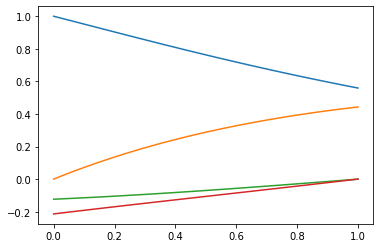

In [ ]:
plt.plot(sol.t, numpy.swapaxes(sol.y, 1, 0))

In [ ]:
u=[]
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
for x in inputs:
  u.append(nn_V(w1, x, consts) )

In [ ]:
u = np.array(u)
s = numpy.swapaxes(sol.y, 1, 0)

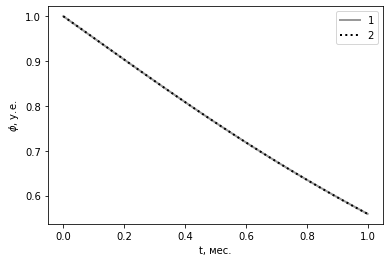

In [ ]:
plt.plot(inputs, u[:, 0],c='0.6', linewidth=2)
plt.plot(sol.t, s[:, 0],':',c='0.0', linewidth=2)
plt.legend(['1', '2'])
plt.gca().set_xlabel('t, мес.')
plt.gca().set_ylabel(r'$\phi$, у.е.')
plt.savefig('/content/gdrive/My Drive/ex2_phi_2.eps')
plt.savefig('/content/gdrive/My Drive/ex2_phi_2.png')

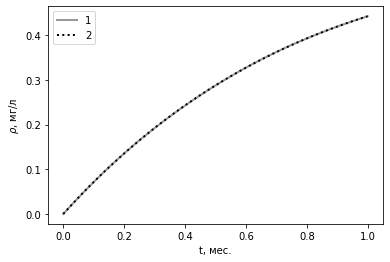

In [ ]:
plt.plot(inputs, u[:, 1],c='0.6', linewidth=2)
plt.plot(sol.t, s[:, 1],':', c='0.0',linewidth=2)
plt.legend(['1', '2'])
plt.gca().set_xlabel('t, мес.')
plt.gca().set_ylabel(r'$\rho$, мг/л')
plt.savefig('/content/gdrive/My Drive/ex2_rho_2.eps')
plt.savefig('/content/gdrive/My Drive/ex2_rho_2.png')

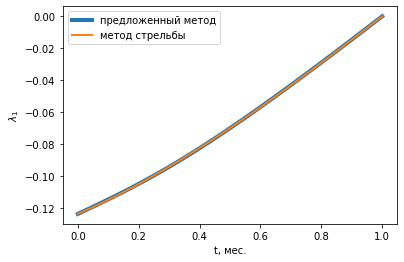

In [ ]:
plt.plot(inputs, u[:, 2], linewidth=4)
plt.plot(sol.t, s[:, 2], linewidth=2)
plt.legend(['предложенный метод', 'метод стрельбы'])
plt.gca().set_xlabel('t, мес.')
plt.gca().set_ylabel(r'$\lambda_1$')
plt.savefig('/content/gdrive/My Drive/ex2_L1.eps')
plt.savefig('/content/gdrive/My Drive/ex2_L1.png')

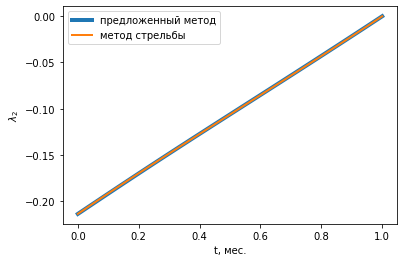

In [ ]:
plt.plot(inputs, u[:, 3], linewidth=4)
plt.plot(sol.t, s[:, 3], linewidth=2)
plt.legend(['предложенный метод', 'метод стрельбы'])
plt.gca().set_xlabel('t, мес.')
plt.gca().set_ylabel(r'$\lambda_2$')
plt.savefig('/content/gdrive/My Drive/ex2_L2.eps')
plt.savefig('/content/gdrive/My Drive/ex2_L2.png')

In [ ]:
s = []
for t, y in zip(sol.t, sol.y.swapaxes(1, 0)):
  s.append(nn_V(w1, t, consts) - y)

In [ ]:
s = numpy.abs(numpy.array(s))

In [ ]:
s[:, 0].max()

0.00024372339

In [ ]:
s[:, 1].max()

0.00030958652

In [ ]:
s[:, 2].max()

0.00024718046

In [ ]:
s[:, 3].max()

0.00021924078